<a href="https://colab.research.google.com/github/mahi97/IE579-GameTheory/blob/master/HW2/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

1. random, numpy -> simple random arrauys and numbers
2. torch -> deseing and optimize GNN
3. dgl -> Used to create GNN layers and model
4. ray -> Just used for tuning hyper parameters
5. networkx -> Generate random graphs 
6. matplotlib -> Plot learning curves

In [ ]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dgl
import dgl.nn as dglnn
  
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import HyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

from networkx.generators.random_graphs import erdos_renyi_graph

import matplotlib.pyplot as plt

Using backend: pytorch


### Easy Plotter Function

In [ ]:
def plot_me(x):
  [plt.plot(l) for l in x]
  plt.ylabel('Running Loss')
  plt.show()
  print([l[-1] for l in x])

# Generating Data

### Generate Random Graphs

For any number of nodes and probability of edge existance

In [ ]:
def generate_random_graph(num_nodes, prob):
  g = erdos_renyi_graph(num_nodes, prob)
  [g.add_edge(i, i) for i in range(num_nodes)] # add self-loop

  # Generate Adj. Matrix of Graph
  a = torch.zeros(num_nodes, num_nodes)
  for n in g.edges:
    a[n[0]][n[1]] = 1.0
    a[n[1]][n[0]] = 1.0
    a[n[0]][n[0]] = 1.0
    a[n[1]][n[1]] = 1.0

  # Generate dgl object of graph 
  u = list(map(lambda x : x[0], g.edges))
  v = list(map(lambda x : x[1], g.edges))  
  g = dgl.graph((torch.tensor(u), torch.tensor(v)))
  g = dgl.add_self_loop(g)

  return g, a

### Data Loader Function

## Generate data dictionary for training GNN

In [ ]:
def data_loader(num_batch):
  w = torch.Tensor([
                  [2.7, 0.0, 1.0],
                  [1.2, 1.3, 0.2],
                  [0.0, 0.5, 0.0],
                  [2.1, 0.0, 1.1],
                  [0.0, 0.0, 0.7]])
  for i in range(num_batch):
    p = random.random()
    g, a =  generate_random_graph(10, p)
    x = torch.rand(10, 5)
    
    yield {
        'feat': x,
        'graph': g,
        'label': torch.matmul(torch.matmul(a, x), w)
        }

# Models

##1. GNN With GraphConv

In [ ]:
class GNN(nn.Module):
    def __init__(self, in_feats, hid_feats, hid2_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats=in_feats, 
                                    out_feats=hid_feats) 
                                    # aggregator_type='mean')
        self.conv2 = dglnn.GraphConv(in_feats=hid_feats, 
                                    out_feats=hid2_feats) 
        self.conv3 = dglnn.GraphConv(in_feats=hid2_feats, 
                                    out_feats=out_feats) 
                                    # aggregator_type='mean')
                                    
    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv3(graph, h)
        return h

## Simple Training Procedure
#### Test Function for evaluationg hyperparamters

In [ ]:
def test(config):
  model = GNN(5, config['h1'], config['h2'], 3)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])

  losses = []
  running_loss = 0
  iter = 0
  for i, data in enumerate(data_loader(config['num_batch'])):
    model.train()
    iter += 1
    g = data['graph']
    x = data['feat']
    labels = data['label']
    outputs = model(g, x)
    loss = criterion(outputs, labels)

    loss.backward()
    # optimizer.step()
    running_loss += loss.item()

    # print statistics
    if i % 1000 == 999:
        print("[%5d] loss: %.3f" % (i + 1, running_loss / iter))
        losses.append(running_loss / iter)
        iter = 0
        running_loss = 0.0

    if i % config['batch_size'] == config['batch_size'] - 1:
        optimizer.step()
        optimizer.zero_grad()

  return losses

In [ ]:
l = test({
    'h1' : 10,
    'h2' : 10,
    'lr' : 1e-3,
    'momentum' : 0.9,
    'num_batch': 20000,
    'batch_size': 1
})

[ 1000] loss: 36.450
[ 2000] loss: 25.412
[ 3000] loss: 22.974
[ 4000] loss: 20.570
[ 5000] loss: 20.422
[ 6000] loss: 17.687
[ 7000] loss: 17.288
[ 8000] loss: 14.989
[ 9000] loss: 17.069
[10000] loss: 14.812
[11000] loss: 14.837
[12000] loss: 14.309
[13000] loss: 15.224
[14000] loss: 14.981
[15000] loss: 14.120
[16000] loss: 14.608
[17000] loss: 13.553
[18000] loss: 13.140
[19000] loss: 13.260
[20000] loss: 14.141


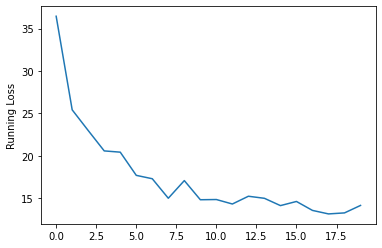

[14.140532826066018]


In [ ]:
plot_me([l])

# Tuning of Hyper-Parameters

## Ray Tune Training Function

In [ ]:
def train(config):
  model = GNN(5, config['h1'], config['h2'], 3)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])


  running_loss = 0
  final = 0
  iter = 0
  for i, data in enumerate(data_loader(config['num_batch'])):
    model.train()
    iter += 1
    g = data['graph']
    x = data['feat']
    labels = data['label']
    outputs = model(g, x)
    loss = criterion(outputs, labels)

    loss.backward()
    # optimizer.step()

    running_loss += loss.item()

    # print statistics
    final = running_loss / iter
    # print statistics
    if i % 1000 == 999:
        print("[%5d] loss: %.3f" % (i + 1, running_loss / iter))
        iter = 0
        running_loss = 0.0

    if i % config['batch_size'] == config['batch_size'] - 1:
        optimizer.step()
        optimizer.zero_grad()

  tune.report(loss=final)
  print("Finished Training")

## Ray Tune Main Scenario

#### What we tune:

1. Number of neurons in first hidden layer (2^n) [1 < n < 8]
2. Number of neurons in second hidden layer (2^n) [1 < n < 8] 
3. Learning Rate [1e-5 < lr < 1e-1]
4. Momentum of SGD [0.5 < m < 1]
5. Batch Size 10^n [0 < n < 4]


In [ ]:
num_batch=20000
num_samples = 24 
config = {
    "h1": tune.sample_from(lambda _: 2 ** np.random.randint(3, 8)),
    "h2": tune.sample_from(lambda _: 2 ** np.random.randint(3, 8)),
    "lr": tune.loguniform(1e-5, 1e-1),
    "num_batch": num_batch,
    "momentum": tune.uniform(0.5, 0.99),
    "batch_size": tune.sample_from(lambda _: 10 ** np.random.randint(0, 4))
}

hyperband = HyperBandScheduler(metric="loss", mode="min")

reporter = CLIReporter(metric_columns=["loss"])

result = tune.run(
    train,
    config=config,
    num_samples=num_samples,
    scheduler=hyperband,
    progress_reporter=reporter
    )

2020-10-18 17:54:29,005	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265
2020-10-18 17:54:29,246	WARNING function_runner.py:486 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2020-10-18 17:54:29,331	WARNING tune.py:396 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


== Status ==
Memory usage on this node: 5.0/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=3
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 4, RUNNING: 1} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=0.0%): {PENDING: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 11} 
Resources requested: 1/12 CPUs, 0/1 GPUs, 0.0/6.88 GiB heap, 0.0/2.34 GiB objects (0/1.0 accelerator_type:GTX)
Result logdir: /home/mahi/ray_results/train
Number of trials: 24 (23 PENDING, 1 RUNNING)
+-------------------+----------+-------+--------------+------+------+-------------+------------+
| Trial name        | status   | loc   |   batch_size |   h1 |   h2 |          lr |   momentum |
|-------------------+----------+-------+--------------+------+------+-------------+------------|
| train_a2047_00001 | PENDING  |       |            1 |   64 |    8 | 0.0737988   |   0.678238 |
| train_a2047_00002 | PENDING  |       |         1000 |    8 | 

(pid=20340) Using backend: pytorch
(pid=20348) Using backend: pytorch
(pid=20338) Using backend: pytorch
(pid=20336) Using backend: pytorch
(pid=20343) Using backend: pytorch
(pid=20342) Using backend: pytorch
(pid=20339) Using backend: pytorch
(pid=20347) Using backend: pytorch
(pid=20344) Using backend: pytorch
(pid=20337) Using backend: pytorch
(pid=20345) Using backend: pytorch
(pid=20346) Using backend: pytorch


(pid=20339) [ 1000] loss: 156.783
(pid=20344) [ 1000] loss: 98.697
(pid=20340) [ 1000] loss: 162.448
(pid=20348) [ 1000] loss: 165.279
(pid=20338) [ 1000] loss: 52.412
(pid=20336) [ 1000] loss: 163.739
(pid=20342) [ 1000] loss: 37.856
(pid=20347) [ 1000] loss: 154.145
(pid=20345) [ 1000] loss: 260.395
(pid=20343) [ 1000] loss: 150.633
(pid=20337) [ 1000] loss: 132186.567
(pid=20346) [ 1000] loss: 41.361
(pid=20348) [ 2000] loss: 41438030.500
(pid=20339) [ 2000] loss: 13326567706.112
(pid=20336) [ 2000] loss: 43.817
(pid=20344) [ 2000] loss: 51.208
(pid=20338) [ 2000] loss: 39.072
(pid=20347) [ 2000] loss: 4253317647.616
(pid=20345) [ 2000] loss: 51.011
(pid=20340) [ 2000] loss: 154.135
(pid=20342) [ 2000] loss: 22.073
(pid=20346) [ 2000] loss: 35.812
(pid=20343) [ 2000] loss: 146.311
(pid=20337) [ 2000] loss: 6639.600
(pid=20339) [ 3000] loss: 8291357859703874912256.000
(pid=20336) [ 3000] loss: 1981.920
(pid=20348) [ 3000] loss: 32248382367973403690795008.000
(pid=20344) [ 3000] loss:

(pid=20487) Using backend: pytorch


Result for train_a2047_00003:
  date: 2020-10-18_17-56-52
  done: false
  experiment_id: f0a2afad0be3435db258411835c3fa72
  experiment_tag: 3_batch_size=1000,h1=64,h2=32,lr=0.0048659,momentum=0.52876
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 20348
  time_since_restore: 141.44317388534546
  time_this_iter_s: 141.44317388534546
  time_total_s: 141.44317388534546
  timestamp: 1603031212
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2047_00003
  
(pid=20348) [20000] loss: nan
(pid=20348) Finished Training


(pid=20599) Using backend: pytorch


Result for train_a2047_00006:
  date: 2020-10-18_17-56-53
  done: false
  experiment_id: 224becb30e0942e8b00dd29a30735bdb
  experiment_tag: 6_batch_size=100,h1=16,h2=128,lr=0.0033796,momentum=0.71747
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 36.8514783771038
  node_ip: 192.168.1.4
  pid: 20337
  time_since_restore: 141.54590582847595
  time_this_iter_s: 141.54590582847595
  time_total_s: 141.54590582847595
  timestamp: 1603031213
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2047_00006
  
(pid=20337) [20000] loss: 36.851
(pid=20337) Finished Training
Result for train_a2047_00008:
  date: 2020-10-18_17-56-53
  done: false
  experiment_id: 50178c6c9d4746b79038d6c4ba5f9ff2
  experiment_tag: 8_batch_size=100,h1=64,h2=32,lr=0.012294,momentum=0.52366
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.84711087560654
  node_ip: 192.168.1.4
  pid: 20345
  time_since_restore: 141.87251806259155
  time_this_it

(pid=20415) Using backend: pytorch
(pid=20452) Using backend: pytorch


Result for train_a2047_00001:
  date: 2020-10-18_17-56-54
  done: false
  experiment_id: b9899752d2304218bddc169393f4c909
  experiment_tag: 1_batch_size=1,h1=64,h2=8,lr=0.073799,momentum=0.67824
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 38.45061930382252
  node_ip: 192.168.1.4
  pid: 20338
  time_since_restore: 143.55269956588745
  time_this_iter_s: 143.55269956588745
  time_total_s: 143.55269956588745
  timestamp: 1603031214
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2047_00001
  
(pid=20338) [20000] loss: 38.451
(pid=20338) Finished Training
Result for train_a2047_00009:
  date: 2020-10-18_17-56-54
  done: false
  experiment_id: 1d9ea3f051ec4086a385b12e472ef1c2
  experiment_tag: 9_batch_size=1000,h1=128,h2=32,lr=0.015815,momentum=0.85233
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 20339
  time_since_restore: 143.51514506340027
  time_this_iter_s: 143.51514

(pid=20548) Using backend: pytorch
(pid=20427) Using backend: pytorch
(pid=20527) Using backend: pytorch


Result for train_a2047_00000:
  date: 2020-10-18_17-56-55
  done: false
  experiment_id: 920709eae8064967bcccafb6461b71f7
  experiment_tag: 0_batch_size=10,h1=128,h2=32,lr=1.1338e-05,momentum=0.5715
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 50.97551909852028
  node_ip: 192.168.1.4
  pid: 20343
  time_since_restore: 143.66589760780334
  time_this_iter_s: 143.66589760780334
  time_total_s: 143.66589760780334
  timestamp: 1603031215
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2047_00000
  
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=3
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=-1.2%): {RUNNING: 1, TERMINATED: 4} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=-1.3%): {RUNNING: 3, TERMINATED: 5} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 3, RUNNING: 8} 
Resources requested: 12/12 CPUs, 0/1 GPUs, 0.0/6.88 GiB heap, 0.0/2.3

(pid=20582) Using backend: pytorch
(pid=20466) Using backend: pytorch
(pid=20530) Using backend: pytorch
(pid=20503) Using backend: pytorch


Result for train_a2047_00005:
  date: 2020-10-18_17-56-58
  done: false
  experiment_id: 1d0b348e19054bbc9117e7e1c3733b9a
  experiment_tag: 5_batch_size=1,h1=32,h2=128,lr=0.0019869,momentum=0.77699
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 12.658275332868099
  node_ip: 192.168.1.4
  pid: 20342
  time_since_restore: 146.8584566116333
  time_this_iter_s: 146.8584566116333
  time_total_s: 146.8584566116333
  timestamp: 1603031218
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2047_00005
  
(pid=20342) [20000] loss: 12.658
(pid=20342) Finished Training
(pid=20487) [ 1000] loss: 52.102


(pid=20924) Using backend: pytorch


(pid=20599) [ 1000] loss: 150.074
(pid=20452) [ 1000] loss: nan
(pid=20415) [ 1000] loss: 94.412
(pid=20527) [ 1000] loss: nan
(pid=20548) [ 1000] loss: nan
(pid=20427) [ 1000] loss: 164.492
(pid=20582) [ 1000] loss: 41.386
(pid=20466) [ 1000] loss: 153.053
(pid=20530) [ 1000] loss: 38.613
(pid=20503) [ 1000] loss: 52.661
(pid=20487) [ 2000] loss: 22.829
(pid=20599) [ 2000] loss: 112.808
(pid=20924) [ 1000] loss: 157.661
(pid=20452) [ 2000] loss: nan
(pid=20527) [ 2000] loss: nan
(pid=20548) [ 2000] loss: nan
(pid=20415) [ 2000] loss: 49.749
(pid=20427) [ 2000] loss: 109.434
(pid=20582) [ 2000] loss: 36.373
(pid=20466) [ 2000] loss: 255051953371873.281
(pid=20503) [ 2000] loss: 23.098
(pid=20530) [ 2000] loss: 38.663
(pid=20487) [ 3000] loss: 19.780
(pid=20599) [ 3000] loss: 66.522
(pid=20924) [ 2000] loss: 122.310
(pid=20452) [ 3000] loss: nan
(pid=20548) [ 3000] loss: nan
(pid=20527) [ 3000] loss: nan
(pid=20415) [ 3000] loss: 43.285
(pid=20427) [ 3000] loss: 1894.757
(pid=20582) [ 3

### Best Hyperparameter of Ray Tune

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

Best trial config: {'h1': 16, 'h2': 64, 'lr': 2.9577306339734983e-05, 'num_batch': 20000, 'momentum': 0.9871012279732239, 'batch_size': 1}
Best trial final validation loss: 10.243699727326632


### Testing the Best of RayTune

In [ ]:
l2 = test(best_trial.config)

[ 1000] loss: 56.992
[ 2000] loss: 27.107
[ 3000] loss: 19.867
[ 4000] loss: 17.406
[ 5000] loss: 16.877
[ 6000] loss: 16.603
[ 7000] loss: 14.255
[ 8000] loss: 14.378
[ 9000] loss: 15.342
[10000] loss: 12.868
[11000] loss: 13.885
[12000] loss: 11.768
[13000] loss: 11.658
[14000] loss: 10.750
[15000] loss: 11.651
[16000] loss: 12.002
[17000] loss: 10.952
[18000] loss: 11.181
[19000] loss: 10.897
[20000] loss: 10.713


### Plot and Comparing

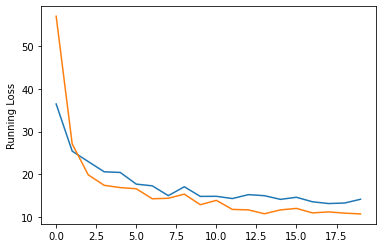

[14.140532826066018, 10.712656000852585]


In [ ]:
plot_me([l,l2])